# Task 4

In this notebook you will find the 4 exercises for the task 4

## Previous steps
Imports and connection

In [23]:
#External imports
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
from datetime import datetime
import holidays
import warnings
from tabulate import tabulate
warnings.filterwarnings('ignore')

#Internal imports
from src.PGConnector.pgconnector import PGConnector

Assuming you have already created the coin_data database on Task 3 (if not, see PGConnector's README).

In [2]:
connector = PGConnector('coin_data')
connector.connect()

INFO:src.PGConnector.pgconnector:Successfully connected to database coin_data


Getting all the data as a dataframe, PGConnector class executes queries and returns as type dataframe:

In [3]:
coin_data = connector.query_coin_data("SELECT * FROM coin_data")  

In [4]:
coin_data.head()

,coin,date,price,json
0,bitcoin,2021-01-01,29022.418395,"{'id': 'bitcoin', 'symbol': 'btc', 'name': 'Bi..."
1,bitcoin,2021-01-02,29352.126792,"{'id': 'bitcoin', 'symbol': 'btc', 'name': 'Bi..."
2,bitcoin,2021-01-03,32163.824935,"{'id': 'bitcoin', 'symbol': 'btc', 'name': 'Bi..."
3,bitcoin,2021-01-04,33008.226203,"{'id': 'bitcoin', 'symbol': 'btc', 'name': 'Bi..."
4,bitcoin,2021-01-05,31515.575967,"{'id': 'bitcoin', 'symbol': 'btc', 'name': 'Bi..."


## Question 1:
Plot the prices of bitcoin, ethereum and cardano for the last 30 days, commit
those plots images in your repo.

For simplicity, I will first turn the dates to datetime:

In [5]:
coin_data['date'] = pd.to_datetime(coin_data['date'], format='%Y-%m-%d')

Now let's plot and save our figure!

In [54]:
def plot_last_30_days(coin_data, save_figure_as=None, title = 'Cryptocurrency Prices - Last 30 Days'):
    # Create a copy to avoid modifying original data
    coin_data = coin_data.copy()
    coin_data['date'] = pd.to_datetime(coin_data['date'])
    
    latest_date = coin_data['date'].max()
    thirty_days_ago = latest_date - pd.Timedelta(days=30)
    
    coin_data_last_30 = coin_data[coin_data['date'] >= thirty_days_ago]
    
    plt.figure(figsize=(8, 4))
    sns.scatterplot(data=coin_data_last_30, x='date', y='price', hue='coin', style='coin')
    
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.xticks(rotation=45)
    plt.legend(title='Cryptocurrency')
    
    plt.tight_layout()
    # Displayed for the notebook
    plt.show()
    
    # Saving as requested
    if save_figure_as is not None:
        plt.savefig(save_figure_as)
    plt.close()

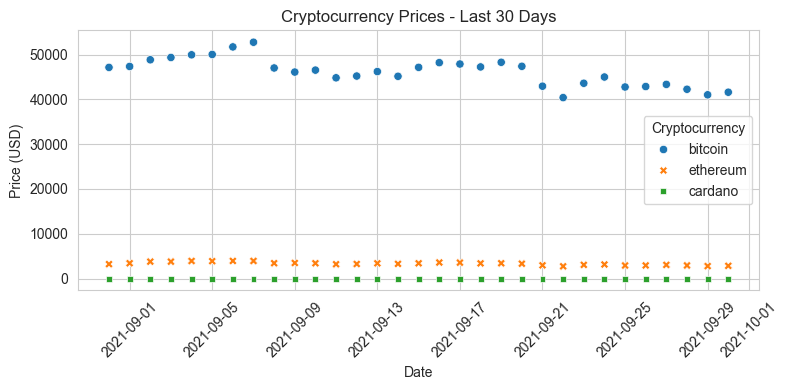

In [58]:
plot_last_30_days(coin_data, save_figure_as='crypto_prices.png')

Let's just plot ethereum and cardano separately:

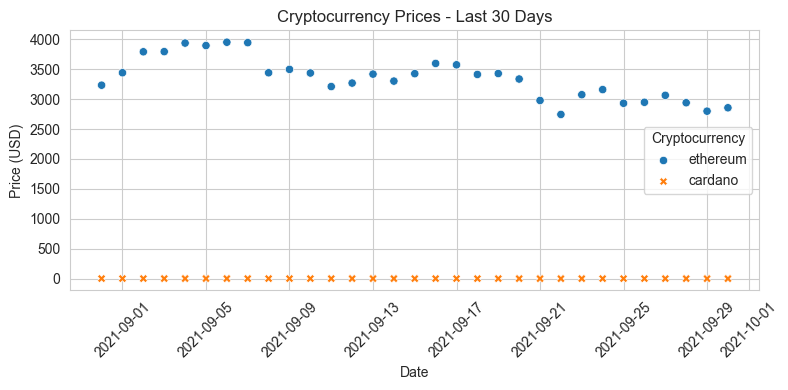

In [56]:
plot_last_30_days(coin_data[coin_data['coin'] != 'bitcoin'])

Interesting, let's see just cardano

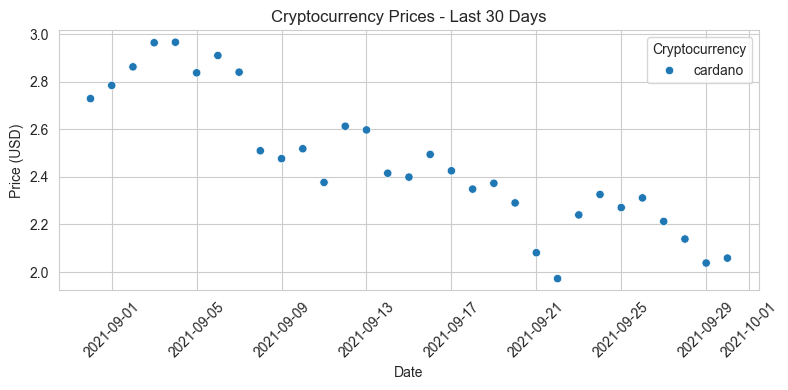

In [57]:
plot_last_30_days(coin_data[coin_data['coin'] == 'cardano'])

## Question 2:
Loading all data from the daily stock value table as a Dataframe, generate the following new
features:


a. Defne 3 types of coins: “High Risk” if it had a 50% price drop on any two consecutive
days, during a given calendar month, “Medium risk” if it dropped more than 20%, and
“Low risk” for the rest (in this same fashion of consecutive days).


b. For each row-day, add a column indicating the general trend of the price for the previous
7 days (T0 vs. T-1 through T-8), and the variance of the price for the same 7 days period.

In [8]:
def calculate_risk_level(group):
    """Calculate risk level based on price drops between consecutive days"""
    pct_change = group['price'].pct_change()
    
    consecutive_drops = (pct_change <= -0.5).rolling(window=2).sum()
    if (consecutive_drops >= 2).any():
        return 'High Risk'
    
    consecutive_drops_medium = (pct_change <= -0.2).rolling(window=2).sum()
    if (consecutive_drops_medium >= 2).any():
        return 'Medium Risk'
    
    return 'Low Risk'

In [9]:
def add_features(coin_data):
    """Add risk level, trend, and variance features to the dataframe"""
    coin_data['date'] = pd.to_datetime(coin_data['date'])
    coin_data = coin_data.sort_values(['coin', 'date'])
    
    # Calculate risk levels for each coin by month
    coin_data['year_month'] = coin_data['date'].dt.to_period('M')
    risk_levels = coin_data.groupby(['coin', 'year_month']).apply(calculate_risk_level)
    
    risk_coin_data = risk_levels.reset_index()
    risk_coin_data.columns = ['coin', 'year_month', 'risk_level']
    
    coin_data = coin_data.merge(risk_coin_data, on=['coin', 'year_month'])
    
    coin_data['price_7d_variance'] = coin_data.groupby('coin')['price'].rolling(window=8, min_periods=8).var().reset_index(0, drop=True)
    
    # Calculate trend (compare current price with 7 days ago)
    coin_data['price_7d_ago'] = coin_data.groupby('coin')['price'].shift(7)
    coin_data['price_trend'] = np.where(coin_data['price'] > coin_data['price_7d_ago'], 'Upward',
                                np.where(coin_data['price'] < coin_data['price_7d_ago'], 'Downward', 'Stable'))

    coin_data = coin_data.drop(['year_month', 'price_7d_ago'], axis=1)
    
    return coin_data

In [10]:
enhanced_coin_data = add_features(coin_data)

print("\nFirst few rows of enhanced dataframe:")
print(enhanced_coin_data.head())

print("\nRisk level distribution:")
print(enhanced_coin_data.groupby('risk_level').size())


First few rows of enhanced dataframe:
      coin       date         price  \
0  bitcoin 2021-01-01  29022.418395   
1  bitcoin 2021-01-02  29352.126792   
2  bitcoin 2021-01-03  32163.824935   
3  bitcoin 2021-01-04  33008.226203   
4  bitcoin 2021-01-05  31515.575967   

                                                json risk_level  \
0  {'id': 'bitcoin', 'symbol': 'btc', 'name': 'Bi...   Low Risk   
1  {'id': 'bitcoin', 'symbol': 'btc', 'name': 'Bi...   Low Risk   
2  {'id': 'bitcoin', 'symbol': 'btc', 'name': 'Bi...   Low Risk   
3  {'id': 'bitcoin', 'symbol': 'btc', 'name': 'Bi...   Low Risk   
4  {'id': 'bitcoin', 'symbol': 'btc', 'name': 'Bi...   Low Risk   

   price_7d_variance price_trend  
0                NaN      Stable  
1                NaN      Stable  
2                NaN      Stable  
3                NaN      Stable  
4                NaN      Stable  

Risk level distribution:
risk_level
Low Risk    819
dtype: int64


## Question 3:

To perform predictions on this time series we’ll need to have a slightly diferent structure in the
dataframe. Instead of having only the price and date for each row (plus the newly generated
features), we’ll also want the price of the last 7 days as columns as well as the next day’s price,
which will be used as a target variable.


a. You can now add extra features if you’d like, for example with feature
scaling or with the skewness of the stock.


b. Add any other time features you’d like such as what day of the week is
this? Is this a weekend or weekday? What week of the year is this? What
month? Etc.


c. Play with the data regarding the volume transacted to create new
features.


d. Bonus: Add extra features for both China’s and US’ holidays using
Python’s holiday package.


In [11]:
def create_time_series_features(coin_data):
    """
    Create time series features including lagged prices, time features,
    and holiday indicators
    """
    coin_data['date'] = pd.to_datetime(coin_data['date'])
    coin_data = coin_data.sort_values(['coin', 'date'])
    
    for i in range(1, 8):
        coin_data[f'price_lag_{i}'] = coin_data.groupby('coin')['price'].shift(i)
    
    # Create target variable (next day's price)
    coin_data['target_price'] = coin_data.groupby('coin')['price'].shift(-1)
    
    # Add basic time features
    coin_data['day_of_week'] = coin_data['date'].dt.dayofweek
    coin_data['is_weekend'] = coin_data['day_of_week'].isin([5, 6]).astype(int)
    coin_data['week_of_year'] = coin_data['date'].dt.isocalendar().week
    coin_data['month'] = coin_data['date'].dt.month
    coin_data['quarter'] = coin_data['date'].dt.quarter
    coin_data['day_of_month'] = coin_data['date'].dt.day
    
    # Create holiday features
    us_holidays = holidays.US()
    cn_holidays = holidays.CN()
    coin_data['is_us_holiday'] = coin_data['date'].map(lambda x: x in us_holidays).astype(int)
    coin_data['is_china_holiday'] = coin_data['date'].map(lambda x: x in cn_holidays).astype(int)
    coin_data['is_any_holiday'] = ((coin_data['is_us_holiday'] + coin_data['is_china_holiday']) > 0).astype(int)
    
    # Price movement features
    coin_data['price_7d_mean'] = coin_data.groupby('coin')['price'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)
    coin_data['price_7d_std'] = coin_data.groupby('coin')['price'].rolling(window=7, min_periods=1).std().reset_index(0, drop=True)
    coin_data['price_7d_skew'] = coin_data.groupby('coin')['price'].rolling(window=7, min_periods=1).skew().reset_index(0, drop=True)
    
    # Volume-based features 
    if 'volume' in coin_data.columns:
        coin_data['volume_7d_mean'] = coin_data.groupby('coin')['volume'].rolling(window=7, min_periods=1).mean().reset_index(0, drop=True)
        coin_data['volume_7d_std'] = coin_data.groupby('coin')['volume'].rolling(window=7, min_periods=1).std().reset_index(0, drop=True)
        coin_data['price_volume_ratio'] = coin_data['price'] / coin_data['volume']
    
    # Feature scaling for numerical columns
    scaler = StandardScaler()
    numerical_cols = ['price'] + [f'price_lag_{i}' for i in range(1, 8)]
    if 'volume' in coin_data.columns:
        numerical_cols.extend(['volume', 'volume_7d_mean', 'volume_7d_std', 'price_volume_ratio'])
    
    coin_data[numerical_cols] = coin_data.groupby('coin')[numerical_cols].transform(
        lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).ravel()
    )
    
    return coin_data

## Question 4:

Regression: For every (coin, date) row in your dataset with date T0, predict the next day’s
price (T1) based on the previous 7 days of the stock’s price (T-7 through T-1). You can use a
simple linear regression model for this task, there’s no need to get fancy with the ML model.

In [38]:
def train_and_predict(df, test_size=0.2, random_state=42):
    """
    Train linear regression model and make predictions for each coin with proper train/test split
    Returns the predictions dataframe and a dictionary of metrics for each coin
    """
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    from sklearn.model_selection import train_test_split
    import numpy as np
    
    predictions = []
    metrics_by_coin = {}
    
    # Define feature columns
    feature_cols = [
        'price_lag_1', 'price_lag_2', 'price_lag_3', 'price_lag_4',
        'price_lag_5', 'price_lag_6', 'price_lag_7',
        'day_of_week', 'is_weekend', 'week_of_year', 'month',
        'price_7d_mean', 'price_7d_std', 'price_7d_skew',
        'is_us_holiday', 'is_china_holiday'
    ]
    
    if 'volume' in df.columns:
        feature_cols.extend(['volume_7d_mean', 'volume_7d_std', 'price_volume_ratio'])
    
    for coin in df['coin'].unique():
        coin_data = df[df['coin'] == coin].copy()
        coin_data = coin_data.dropna(subset=feature_cols + ['target_price'])
        
        if len(coin_data) > 0:
            X = coin_data[feature_cols]
            y = coin_data['target_price']
            
            # Split the data into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_size, random_state=random_state
            )
            
            # Train the model
            model = LinearRegression()
            model.fit(X_train, y_train)
            
            # Make predictions on both train and test sets
            train_predictions = model.predict(X_train)
            test_predictions = model.predict(X_test)
            
            # Store predictions in original dataframe
            train_indices = X_train.index
            test_indices = X_test.index
            
            coin_data.loc[train_indices, 'predicted_price'] = train_predictions
            coin_data.loc[test_indices, 'predicted_price'] = test_predictions
            coin_data.loc[train_indices, 'is_test'] = False
            coin_data.loc[test_indices, 'is_test'] = True
            
            # Calculate metrics for test set
            test_mse = mean_squared_error(y_test, test_predictions)
            test_rmse = np.sqrt(test_mse)
            test_mae = mean_absolute_error(y_test, test_predictions)
            test_r2 = r2_score(y_test, test_predictions)
            
            # Calculate adjusted R-squared for test set
            n = len(y_test)
            p = len(feature_cols)
            test_adjusted_r2 = 1 - (1 - test_r2) * (n - 1) / (n - p - 1)
            
            # Calculate MAPE for test set
            test_mape = np.mean(np.abs((y_test - test_predictions) / y_test)) * 100
            
            # Calculate training metrics for comparison
            train_mse = mean_squared_error(y_train, train_predictions)
            train_r2 = r2_score(y_train, train_predictions)
            train_mape = np.mean(np.abs((y_train - train_predictions) / y_train)) * 100
            
            # Store metrics for this coin
            metrics_by_coin[coin] = {
                'test_mse': test_mse,
                'test_rmse': test_rmse,
                'test_mae': test_mae,
                'test_r2': test_r2,
                'test_adjusted_r2': test_adjusted_r2,
                'test_mape': test_mape,
                'train_mse': train_mse,
                'train_r2': train_r2,
                'train_mape': train_mape,
                'feature_coefficients': dict(zip(feature_cols, model.coef_)),
                'intercept': model.intercept_,
                'n_observations_train': len(y_train),
                'n_observations_test': len(y_test)
            }
            
            predictions.append(coin_data)
    
    final_df = pd.concat(predictions)
    
    # Add error columns to final dataframe
    final_df['prediction_error'] = final_df['target_price'] - final_df['predicted_price']
    final_df['absolute_error'] = abs(final_df['prediction_error'])
    final_df['percentage_error'] = (final_df['prediction_error'] / final_df['target_price']) * 100
    
    return final_df, metrics_by_coin

For displaying the metrics

In [51]:
def display_metrics(predictions_df, metrics_by_coin):
    """
    Display prediction metrics in a clean, organized format with enhanced error handling
    """
    predictions_df['is_test'] = predictions_df['is_test'].astype(bool)
    
    # Verify data integrity
    print("\nData Integrity Check:")
    print(f"Any missing values in key columns:")
    print(predictions_df[['coin', 'is_test', 'absolute_error']].isnull().sum())
    
    try:
        # Create separate summaries for train and test sets using more robust groupby
        train_data = predictions_df[~predictions_df['is_test']]
        test_data = predictions_df[predictions_df['is_test']]
        
        print(f"\nTrain data shape: {train_data.shape}")
        print(f"Test data shape: {test_data.shape}")
        
        train_error_summary = (train_data
            .groupby('coin', as_index=False)['absolute_error']
            .agg([
                ('Train Mean Absolute Error', 'mean'),
                ('Train Std of Error', 'std'),
                ('Train Min Error', 'min'),
                ('Train Max Error', 'max')
            ])
            .round(4)
        )
        
        test_error_summary = (test_data
            .groupby('coin', as_index=False)['absolute_error']
            .agg([
                ('Test Mean Absolute Error', 'mean'),
                ('Test Std of Error', 'std'),
                ('Test Min Error', 'min'),
                ('Test Max Error', 'max')
            ])
            .round(4)
        )
        
        # Create detailed metrics DataFrame with error handling
        metrics_rows = []
        for coin, metric in metrics_by_coin.items():
            try:
                metrics_rows.append({
                    'Coin': coin,
                    'Test RMSE': f"{metric['test_rmse']:.4f}",
                    'Test MAE': f"{metric['test_mae']:.4f}",
                    'Test R²': f"{metric['test_r2']:.4f}",
                    'Test MAPE (%)': f"{metric['test_mape']:.2f}",
                    'Train R²': f"{metric['train_r2']:.4f}",
                    'Train MAPE (%)': f"{metric['train_mape']:.2f}",
                    'Train Size': metric['n_observations_train'],
                    'Test Size': metric['n_observations_test']
                })
            except KeyError as e:
                print(f"Warning: Missing metric for coin {coin}: {e}")
                continue
        
        metrics_df = pd.DataFrame(metrics_rows)
        metrics_df = metrics_df.set_index('Coin')
        
        # Display results
        print("\n=== Training Set Error Summary ===")
        print(tabulate(train_error_summary, headers='keys', tablefmt='pretty'))
        
        print("\n=== Test Set Error Summary ===")
        print(tabulate(test_error_summary, headers='keys', tablefmt='pretty'))
        
        print("\n=== Model Performance Metrics ===")
        print(tabulate(metrics_df, headers='keys', tablefmt='pretty'))
        
        # Display feature importance for each coin
        print("\n=== Top 5 Most Important Features by Coin ===")
        for coin, metric in metrics_by_coin.items():
            if 'feature_coefficients' in metric:
                coef = pd.Series(metric['feature_coefficients'])
                top_features = coef.abs().nlargest(5)
                
                print(f"\n{coin}:")
                for feature, value in top_features.items():
                    print(f"  {feature}: {value:.4f}")
            else:
                print(f"\nWarning: No feature coefficients available for {coin}")

        # Calculate and display average metrics across all coins
        try:
            avg_metrics = {
                'Average Test R²': np.mean([m['test_r2'] for m in metrics_by_coin.values()]),
                'Average Test RMSE': np.mean([m['test_rmse'] for m in metrics_by_coin.values()]),
                'Average Test MAPE (%)': np.mean([m['test_mape'] for m in metrics_by_coin.values()]),
                'Average Train R²': np.mean([m['train_r2'] for m in metrics_by_coin.values()]),
                'Average Train MAPE (%)': np.mean([m['train_mape'] for m in metrics_by_coin.values()])
            }
            
            print("\n=== Average Metrics Across All Coins ===")
            for metric, value in avg_metrics.items():
                print(f"{metric}: {value:.4f}")
        except Exception as e:
            print(f"\nWarning: Could not calculate average metrics: {e}")
            
    except Exception as e:
        print(f"\nError occurred: {str(e)}")
        print("\nDataFrame sample:")
        print(predictions_df.head())
        print("\nDataFrame info:")
        print(predictions_df.info())
        raise

Using all of the above

In [47]:
enhanced_coin_data = create_time_series_features(coin_data)
predictions_coin_data, metrics_by_coin = train_and_predict(enhanced_coin_data)

In [52]:
display_metrics(predictions_coin_data, metrics_by_coin)


Data Integrity Check:
Any missing values in key columns:
coin              0
is_test           0
absolute_error    0
dtype: int64

Train data shape: (636, 29)
Test data shape: (159, 29)

=== Training Set Error Summary ===
+---+----------+---------------------------+--------------------+-----------------+-----------------+
|   |   coin   | Train Mean Absolute Error | Train Std of Error | Train Min Error | Train Max Error |
+---+----------+---------------------------+--------------------+-----------------+-----------------+
| 0 | bitcoin  |         1370.4708         |     1167.0889      |     53.4867     |    6590.1797    |
| 1 | cardano  |           0.068           |       0.0687       |       0.0       |     0.4266      |
| 2 | ethereum |          93.4459          |       92.053       |      0.436      |    670.7082     |
+---+----------+---------------------------+--------------------+-----------------+-----------------+

=== Test Set Error Summary ===
+---+----------+---------------

Save the results

In [53]:
predictions_coin_data.to_csv('crypto_predictions.csv', index=False)

Plots

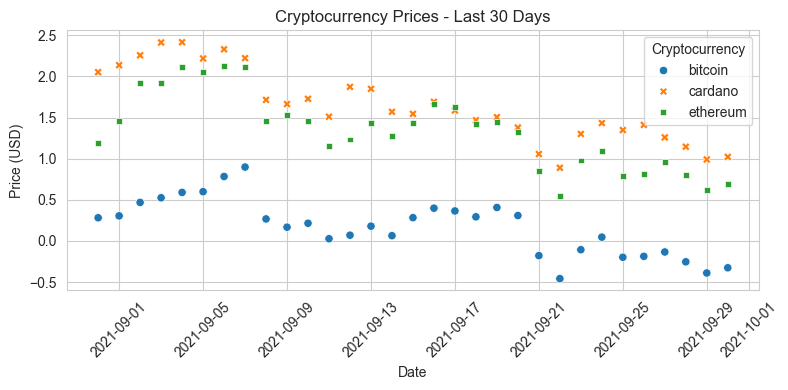

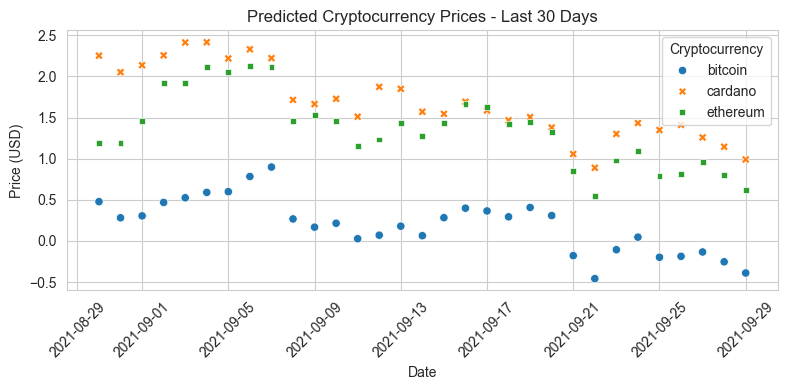

In [49]:
plot_last_30_days(enhanced_coin_data)
plot_last_30_days(predictions_coin_data, title= 'Predicted Cryptocurrency Prices - Last 30 Days')